# 0.0 Set Up

In [ ]:
import tarfile
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

tar_file_path = '/content/drive/My Drive/datasets.tar'
json_files = 'datasets'  # Assuming 'datasets' is a folder inside the tar archive

try:
  with tarfile.open(tar_file_path, 'r') as tar_ref:
    tar_ref.extractall('/content/datasets')  # Extract to a temporary directory

  # Assuming 'datasets' is a folder containing your CSV file
  df = pd.read_csv(f'/content/datasets/{json_files}/your_csv_file.csv')
  # Replace 'your_csv_file.csv' with the actual file name

except FileNotFoundError:
  print(f"Error: File not found at {tar_file_path}")
except KeyError:
  print(f"Error: File or directory {json_files} not found inside the tar archive.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Mounted at /content/drive
Error: File not found at /content/drive/My Drive/datasets.tar


## 1.0 Imports - !pip install <package_name> if necessary

In [ ]:
import pandas as pd
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import numpy as np
from tqdm.auto import tqdm


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')  # For lemmatization


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## 0.1 Helper Functions

In [ ]:
def load_json_data(file_path):
    with open(file_path, "r") as file:
        contents = json.load(file)
    return contents


def create_tfidf_matrix(citing_dataset, nonciting_dataset, vectorizer=TfidfVectorizer()):
    """
    Creates TF-IDF matrix for the given citing and non-citing datasets based on the specified text column.

    Parameters:
    citing_dataset (json)): DataFrame containing citing patents.
    nonciting_dataset (json): DataFrame containing non-citing patents.
    vectorizer (TfidfVectorizer, optional): TfidfVectorizer object for vectorizing text data.
                                             Defaults to TfidfVectorizer().

    Returns:
    tuple: A tuple containing TF-IDF matrices for citing and non-citing patents respectively.
           (tfidf_matrix_citing, tfidf_matrix_nonciting)
    """
    all_text = [patent['text'] for patent in citing_dataset + nonciting_dataset]

    # Vectorizing descriptions
    print("Vectorizing descriptions...")
    tfidf_matrix = vectorizer.fit_transform(tqdm(all_text, desc="TF-IDF"))

    # Since we're interested in similarities between citing and cited patents,
    # we need to split the TF-IDF matrix back into two parts
    split_index = len(citing_dataset)
    tfidf_matrix_citing = tfidf_matrix[:split_index]
    tfidf_matrix_nonciting = tfidf_matrix[split_index:]

    # Size of vocabulary
    print("Size of vocabulary:", len(vectorizer.vocabulary_))

    return tfidf_matrix_citing, tfidf_matrix_nonciting



def get_mapping_dict(mapping_df):
    """
    Creates dictionary of citing ids to non-citing id based on given dataframe (which is based on providedjson)

    Parameters:
    mapping_df (DataFrame): DataFrame containing mapping between citing and cited patents
    Returns:
    dict: dictionary of unique citing patent ids to list of cited patent ids
    """
    mapping_dict = {}

    for _, row in mapping_df.iterrows():
        key = row[0]  # Value from column 0
        value = row[2]  # Value from column 2
        if key in mapping_dict:
            mapping_dict[key].append(value)
        else:
            mapping_dict[key] = [value]

    return mapping_dict

def create_corpus(corpus, text_type):
    """
    Extracts text data from a corpus based on the specified text type.

    Parameters:
    corpus (list): List of dictionaries representing patent documents.
    text_type (str): Type of text to extract ('title', 'abstract', 'claim1', 'claims', 'description', 'fulltext').

    Returns:
    list: List of dictionaries with 'id' and 'text' keys representing each document in the corpus.
    """

    app_ids = [doc['Application_Number'] + doc['Application_Category'] for doc in corpus]

    cnt = 0 # count the number of documents without text
    texts = []  # list of texts
    ids_to_remove = []  # list of ids of documents without text, to remove them from the corpus

    if text_type == 'title':
        for doc in corpus:
            try:
                texts.append(doc['Content']['title'])
            except: # if the document does not have a title
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without title: {cnt}")

    elif text_type == 'abstract':
        for doc in corpus:
            try:
                texts.append(doc['Content']['pa01'])
            except: # if the document does not have an abstract
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without abstract: {cnt}")

    elif text_type == 'claim1':
        for doc in corpus:
            try:
                texts.append(doc['Content']['c-en-0001'])
            except: # if the document does not have claim 1
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without claim 1: {cnt}")

    elif text_type == 'claims':
        # all the values with the key starting with 'c-en-', each element in the final list is a list of claims
        for doc in corpus:
            doc_claims = []
            for key in doc['Content'].keys():
                if key.startswith('c-en-'):
                    doc_claims.append(doc['Content'][key])
            if len(doc_claims) == 0:    # if the document does not have any claims
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_claims)
                texts.append(doc_text_string)
        print(f"Number of documents without claims: {cnt}")

    elif text_type == 'description':
        # all the values with the key starting with 'p'
        for doc in corpus:
            doc_text = []
            for key in doc['Content'].keys():
                if key.startswith('p'):
                    doc_text.append(doc['Content'][key])
            if len(doc_text) == 0:  # if the document does not have any description
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_text)
                texts.append(doc_text_string)
        print(f"Number of documents without description: {cnt}")

    elif text_type == 'fulltext':
        for doc in corpus:
            doc_text = list(doc['Content'].values())
            doc_text_string = ' '.join(doc_text)
            texts.append(doc_text_string)
        if cnt > 0:
            print(f"Number of documents without any text: {cnt}")

    else:
        raise ValueError("Invalid text type")

    if len(ids_to_remove) > 0:
        print(f"Removing {len(ids_to_remove)} documents without required text")
        for id_ in ids_to_remove[::-1]:
            idx = app_ids.index(id_)
            del app_ids[idx]

    # Create a list of dictionaries with app_ids and texts
    corpus_data = [{'id': app_id, 'text': text} for app_id, text in zip(app_ids, texts)]

    return corpus_data


def get_true_and_predicted(citing_to_cited_dict, recommendations_dict):
    """
    Get the true and predicted labels for the metrics calculation.

    Parameters:
    citing_to_cited_dict : dict of str : list of str
        Mapping between citing patents and the list of their cited patents (groud truth)
    recommendations_dict : dict of str : list of str
        Mapping between citing patents and the sorted list of recommended patents (predictions)

    Returns:
    list of list
        True relevant items for each recommendation list.
    list of list
        Predicted recommended items for each recommendation list.
    int
        Number of patents not in the citation mapping
    """
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []
    not_in_citation_mapping = 0

    # Iterate over the items in both dictionaries
    for citing_id in recommendations_dict.keys():
        # Check if the citing_id is present in both dictionaries
        if citing_id in citing_to_cited_dict:
            # If yes, append the recommended items from both dictionaries to the respective lists
            true_labels.append(citing_to_cited_dict[citing_id])
            predicted_labels.append(recommendations_dict[citing_id])
        else:
            not_in_citation_mapping += 1

    return true_labels, predicted_labels, not_in_citation_mapping



def mean_recall_at_k(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Recall@k for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Recall@k value.
    """
    recalls_at_k = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Recall@k for each recommendation list
        true_set = set(true)
        k = min(k, len(pred))
        relevant_count = sum(1 for item in pred[:k] if item in true_set)
        recalls_at_k.append(relevant_count / len(true_set))

    # Calculate the mean Recall@k
    mean_recall = sum(recalls_at_k) / len(recalls_at_k)

    return mean_recall

def mean_inv_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean inverse rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean inverse rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the inverse rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = 1 / (pred.index(item) + 1)
            except ValueError:
                rank = 0  # If item not found, assign 0
            ranks.append(rank)

        # Calculate the mean inverse rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean inverse ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks


def mean_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = pred.index(item) + 1
            except ValueError:
                rank = len(pred)  # If item not found, assign the length of the list
            ranks.append(rank)

        # Calculate the mean rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks



def mean_average_precision(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Average Precision for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Average Precision value.
    """
    average_precisions = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Average Precision for each recommendation list
        true_set = set(true)
        precision_at_k = []
        relevant_count = 0
        for i, item in enumerate(pred[:k]):
            if item in true_set:
                relevant_count += 1
                precision_at_k.append(relevant_count / (i + 1))
        average_precision = sum(precision_at_k) / len(true_set)
        average_precisions.append(average_precision)

    # Calculate the mean Average Precision
    mean_average_precision = sum(average_precisions) / len(average_precisions)

    return mean_average_precision

def top_k_ranks(citing, cited, cosine_similarities, k=10):
    # Create a dictionary to store the top k ranks for each citing patent
    top_k_ranks = {}
    for i, content_id in enumerate(citing):
        top_k_ranks[content_id['id']] = [cited[j]['id'] for j in np.argsort(cosine_similarities[i])[::-1][:k]]
    return top_k_ranks


# 1.0 Load Datasets

In [ ]:
json_citing_train = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TRAIN.json")
json_citing_test = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TEST.json")

json_nonciting = load_json_data("./datasets/Content_JSONs/Cited_2020_Uncited_2010-2019_Cleaned_Content_22k/CLEANED_CONTENT_DATASET_cited_patents_by_2020_uncited_2010-2019.json")
json_citing_to_cited = load_json_data("./datasets/Citation_JSONs/Citation_Train.json") # Citing ids are unique


In [ ]:
citing_dataset_df = pd.DataFrame(json_citing_train)

nonciting_dataset_df = pd.DataFrame(json_nonciting)
mapping_dataset_df = pd.DataFrame(json_citing_to_cited)


In [ ]:
citing_dataset_df

,Application_Number,Application_Date,Application_Category,Content
0,3650293,2020-05-13,A1,{'title': 'DEVICE FOR CONTROLLING THE BRAKING ...
1,3694265,2020-08-12,A1,{'title': 'TIME DIVISION MULTIPLEXING OF SYNCH...
2,3623522,2020-03-18,A1,{'title': 'LAUNDRY MACHINE AND CONTROL METHOD ...
3,3611147,2020-02-19,A1,{'title': 'CHEMICAL AND TOPOLOGICAL SURFACE MO...
4,3640454,2020-04-22,A1,"{'title': 'FUEL METERING SYSTEM', 'pa01': 'The..."
...,...,...,...,...
6826,3741587,2020-11-25,A1,{'title': 'AUTO-LOCATION USING TIRE MOUNTED SY...
6827,3693248,2020-08-12,A1,{'title': 'HOLE COVER AND STEERING SYSTEM INCL...
6828,3628962,2020-04-01,A1,{'title': 'SYSTEM AND METHOD FOR MEASURING CLE...
6829,3620899,2020-03-11,A1,{'title': 'TOUCH SCREEN AND DISPLAY APPARATUS'...


In [ ]:
print(citing_dataset_df.info())
print(citing_dataset_df.describe())
print(citing_dataset_df.columns)
print(citing_dataset_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Application_Number    6831 non-null   object
 1   Application_Date      6831 non-null   object
 2   Application_Category  6831 non-null   object
 3   Content               6831 non-null   object
dtypes: object(4)
memory usage: 213.6+ KB
None
       Application_Number Application_Date Application_Category  \
count                6831             6831                 6831   
unique               6829               53                    2   
top               3621312       2020-06-24                   A1   
freq                    2              262                 6829   

                                                  Content  
count                                                6831  
unique                                               6829  
top     {'title': 'FILM WRAPPIN

In [ ]:
nonciting_dataset_df


,Application_Number,Application_Date,Application_Category,Content
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',..."
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u..."
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...
...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v..."
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en..."
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...


In [ ]:
print(nonciting_dataset_df.info())
print(nonciting_dataset_df.describe())
print(nonciting_dataset_df.columns)
print(nonciting_dataset_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16837 entries, 0 to 16836
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Application_Number    16837 non-null  object
 1   Application_Date      16837 non-null  object
 2   Application_Category  16837 non-null  object
 3   Content               16837 non-null  object
dtypes: object(4)
memory usage: 526.3+ KB
None
       Application_Number Application_Date Application_Category  \
count               16837            16837                16837   
unique              16807              539                    6   
top               1781260       2013-02-27                   B1   
freq                    2               99                 7932   

                                                  Content  
count                                               16837  
unique                                              16836  
top     {'title': 'FUSED CYCL

In [ ]:
mapping_dataset_df

,0,1,2,3,4
0,3712070A1,[c-en-0004],3354576A1,"[p0024, p0027, c-en-0012, c-en-0013]",A
1,3675165A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3336831A2,"[p0045, p0046, p0047, p0048, p0049, p0050, p00...",A
2,3599626A1,"[c-en-0002, c-en-0003, c-en-0004, c-en-0005, c...",2453448A1,"[p0029, p0030]",A
3,3705201A1,"[c-en-0001, c-en-0002, c-en-0004, c-en-0006, c...",2468433A2,"[p0011, p0012, p0013, p0014, p0015, p0016, p00...",X
4,3628210A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3369366A1,[pa01],A
...,...,...,...,...,...
8589,3623977A1,"[c-en-0008, c-en-0009, c-en-0010, c-en-0011, c...",2518981A1,"[p0021, p0022, p0023, p0024, p0025, p0026, p00...",A
8590,3721843A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3213727A1,"[p0015, p0016, p0017, p0018, p0019, p0020, p00...",X
8591,3708263A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3217171A1,"[pa01, p0010, p0014, p0003, p0009, p0016]",A
8592,3588557A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",2988328A1,"[p0047, p0012]",A


In [ ]:
mapping_dict = get_mapping_dict(mapping_dataset_df)
mapping_dict


{'3712070A1': ['3354576A1'],
 '3675165A1': ['3336831A2'],
 '3599626A1': ['2453448A1'],
 '3705201A1': ['2468433A2'],
 '3628210A1': ['3369366A1'],
 '3637504A1': ['2482368A1'],
 '3758169A1': ['2575411A1'],
 '3597767A1': ['2226127A1'],
 '3588532A1': ['2879156A1'],
 '3670817A1': ['3231978A1'],
 '3702079A1': ['3338931A1'],
 '3668068A1': ['3116204A1'],
 '3750631A1': ['3132851A1'],
 '3599082A1': ['2730353A1'],
 '3587089A1': ['3028845A1'],
 '3605854A1': ['3319239A1'],
 '3607862A1': ['2815685A1'],
 '3742402A1': ['3361724A2'],
 '3705896A1': ['2743710A1'],
 '3587065A1': ['2689910A1'],
 '3739813A1': ['2584496A1'],
 '3624050A1': ['2887642A2'],
 '3719445A1': ['2778606A1'],
 '3599363A1': ['3486467A2'],
 '3747742A1': ['2783951A1'],
 '3742709A1': ['3101560A1'],
 '3667442A1': ['2808242A1'],
 '3670124A1': ['2826608A1'],
 '3715223A1': ['2815953A1'],
 '3686680A1': ['3435167A1'],
 '3723272A1': ['3076542A1'],
 '3674167A1': ['2447130A1'],
 '3689738A1': ['3263446A1'],
 '3606117A1': ['3267699A1'],
 '3670347A1': 

In [ ]:
#import ast
#nonciting_dataset_df['all_content'] = nonciting_dataset_df['Content'].apply(ast.literal_eval)

## Comments:

Let’s analyze your datasets based on the outputs you’ve shared. Here’s a structured breakdown:

---

### **1. `citing_dataset_df` (Citing Patents – Queries)**
- **Size**: 6,831 patents (rows).  
- **Columns**:  
  - `Application_Number`: Unique ID for citing patents (e.g., `3597545A1`).  
  - `Application_Date`: Dates in 2020 (matches the dataset name "Citing_2020").  
  - `Application_Category`: Mostly `A1` (patent type).  
  - `Content`: Nested JSON with patent text sections (title, claims, descriptions, etc.).  

#### **Key Observations**:
- **Duplicate Application Numbers**:  
  `Application_Number` has 6,829 unique values but 6,831 rows → **2 duplicates**.  
  Example: `3621312` appears twice. This could cause issues (e.g., ambiguous queries).  
- **Text Extraction**:  
  The `Content` field contains structured text (e.g., `title`, `pa01` [likely abstract], `c-en-0001` [claim 1], etc.).  
  Use `create_corpus()` to extract specific text types (e.g., `text_type='abstract'`).  

---

### **2. `nonciting_dataset_df` (Cited/Uncited Patents – Corpus)**
- **Size**: 16,837 patents (rows).  
- **Columns**: Same structure as `citing_dataset_df`.  
- **Time Range**:  
  - `Application_Date` spans 2010–2019 (matches "Cited_2020_Uncited_2010-2019").  
  - Includes **cited patents** (ground truth) and **uncited patents** (distractors).  

#### **Key Observations**:
- **Application Categories**:  
  Mostly `B1` (7,932 entries) and `A1/A2`. Categories may indicate patent types or jurisdictions.  
- **Potential Noise**:  
  `Content` for some patents may be incomplete (e.g., missing claims or descriptions).  
  Use `create_corpus()` to filter out patents with missing text (e.g., `text_type='claims'`).  

---

### **3. `mapping_dataset_df` (Gold Mapping)**
- **Size**: 8,594 rows (citing-to-cited pairs).  
- **Structure**:  
  - Column `0`: Citing patent ID (e.g., `3712070A1`).  
  - Column `2`: Cited patent ID (e.g., `3354576A1`).  
  - Other columns (1, 3, 4): Likely metadata (e.g., claim numbers or paragraphs where citations appear).  

#### **Key Observations**:
- **Mapping Completeness**:  
  The resulting `mapping_dict` has ~8,594 entries (assuming no duplicates in column `0`).  
  Example: `{"3712070A1": ["3354576A1"], ...}`.  
- **Implications for Evaluation**:  
  Each citing patent in `citing_dataset_df` may have 1+ cited patents in `nonciting_dataset_df`.  

---

### **4. Critical Insights for Your Project**
#### **(a) Data Challenges**
- **Duplicate IDs**:  
  - `citing_dataset_df` has 2 duplicate `Application_Number`s. Resolve these (e.g., drop duplicates).  
- **Text Completeness**:  
  - Some patents in `nonciting_dataset_df` might lack claims/descriptions. Use `create_corpus()` to filter them out.  
- **Temporal Consistency**:  
  - Citing patents are from **2020**, while cited/uncited patents are from **2010–2019** (as expected for prior art).  

#### **(b) Evaluation Setup**
- **Ground Truth**: `mapping_dict` defines true cited patents for each query.  
- **Corpus Size**: 16,837 patents → A **retrieval task with moderate scale** (top-100 from ~16k candidates).  

#### **(c) Text Extraction Strategy**
- **Best Fields for Retrieval**:  
  - `title` is short but may lack detail.  
  - `claims` or `description` are richer but longer.  
  - Experiment with `text_type` in `create_corpus()` to see which performs best (e.g., `abstract` vs. `claims`).  

---

### **5. Next Steps**
1. **Resolve Duplicates**:  
   ```python
   citing_dataset_df.drop_duplicates(subset=["Application_Number"], inplace=True)
   ```
2. **Extract Text**:  
   ```python
   citing_corpus = create_corpus(json_citing_train, text_type="abstract")
   nonciting_corpus = create_corpus(json_nonciting, text_type="abstract")
   ```
3. **Validate Mapping**:  
   Ensure all cited patents in `mapping_dict` exist in `nonciting_dataset_df` (to avoid missing ground truth).  

Let me know if you’d like help with any of these steps!

## 1.1 Take a look at the content

In [ ]:
nonciting_dataset_df.loc[0].Content

{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',
 'c-en-0001': 'A vehicle support assembly, comprising: first and second tilting wheels (421A, 421B; 16, 16) disposed respectively at different lateral positions with respect to a longitudinal axis; a tilt-mechanism (431; 17) configured for supportively associating a vehicle body (402) from the tilting wheels (421A, 421B; 16, 16) to enable the vehicle body (402) to tilt substantially through a first tilt range with respect to a surface (428) on which the tilting wheels (421A, 421B; 16, 16) are disposed; a tilt-limiter (450, 550, 650) operably associated with the tilt-mechanism (431) to restrict the tilting of the vehicle body (402) to less than the first tilt range, and releasable to allow the tilting through the first tilt range; characterised in that the vehicle support assembly further comprises : an inclination sensor configured to sense an inclination of the vehicle (130, 430) with respect to the vertical at least when the vehicle is a

## 1.2 Create a column with the Title

Note for lateR: Try all text content by uncommenting the below

In [ ]:
#import ast
#nonciting_dataset_df['all_content'] = nonciting_dataset_df['Content'].apply(ast.literal_eval)

In [ ]:
def extract_title(dictionary):
    return dictionary.get('title', None)  # Return None if 'title' key is not present

nonciting_dataset_df['Title'] = nonciting_dataset_df['Content'].apply(extract_title)
citing_dataset_df['Title'] = citing_dataset_df['Content'].apply(extract_title)

nonciting_dataset_df


,Application_Number,Application_Date,Application_Category,Content,Title
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',...",VEHICLE WITH LOCKABLE TILT SYSTEM
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u...",UNIVERSAL JOINT
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog...","Apparatus, method and computer program product..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...,Method and apparatus for forming a rubber article
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...,Heat exchanger mounting assembly in a gas turbine
...,...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v...","Synchronization of a split audio, video, or ot..."
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...,Fluid handling unit and fluid handling apparat...
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en...",Oil pump system for vehicle
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...,Apparatus for construction of quasi orthogonal...


# 1.3 Average title length

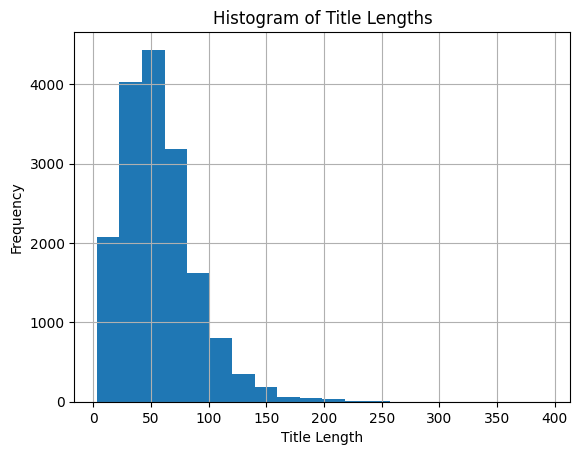

In [ ]:
plt.hist(nonciting_dataset_df['Title'].str.len(), bins=20)
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.title('Histogram of Title Lengths')
plt.grid(True)
plt.show()

In [ ]:
# Compute histogram data
title_lengths = nonciting_dataset_df['Title'].str.len()
counts, bin_edges = np.histogram(title_lengths, bins=20)

# Print the results
for i in range(len(bin_edges) - 1):
    print(f"Bin {i+1}: {bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}, Frequency: {counts[i]}")


Bin 1: 3.0 - 22.6, Frequency: 2080
Bin 2: 22.6 - 42.1, Frequency: 4024
Bin 3: 42.1 - 61.7, Frequency: 4435
Bin 4: 61.7 - 81.2, Frequency: 3184
Bin 5: 81.2 - 100.8, Frequency: 1624
Bin 6: 100.8 - 120.3, Frequency: 802
Bin 7: 120.3 - 139.8, Frequency: 353
Bin 8: 139.8 - 159.4, Frequency: 181
Bin 9: 159.4 - 179.0, Frequency: 64
Bin 10: 179.0 - 198.5, Frequency: 43
Bin 11: 198.5 - 218.1, Frequency: 28
Bin 12: 218.1 - 237.6, Frequency: 6
Bin 13: 237.6 - 257.1, Frequency: 8
Bin 14: 257.1 - 276.7, Frequency: 2
Bin 15: 276.7 - 296.2, Frequency: 0
Bin 16: 296.2 - 315.8, Frequency: 1
Bin 17: 315.8 - 335.4, Frequency: 1
Bin 18: 335.4 - 354.9, Frequency: 0
Bin 19: 354.9 - 374.4, Frequency: 0
Bin 20: 374.4 - 394.0, Frequency: 1


## 1.3 Number of CITED patents per citing patent

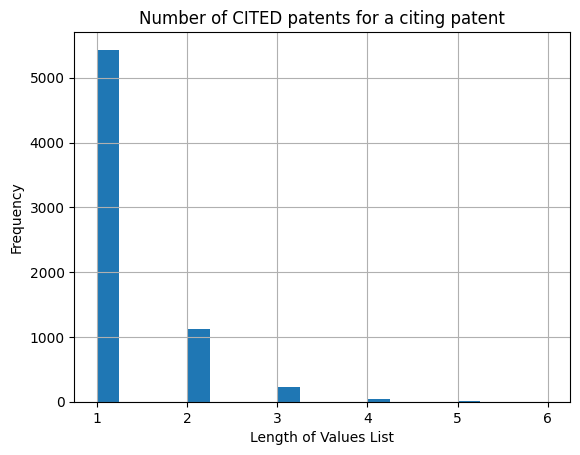

In [ ]:
list_lengths = [len(values) for values in mapping_dict.values()]

plt.hist(list_lengths, bins=20)
plt.xlabel('Length of Values List')
plt.ylabel('Frequency')
plt.title('Number of CITED patents for a citing patent')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Compute list lengths
list_lengths = [len(values) for values in mapping_dict.values()]

# Compute histogram data
counts, bin_edges = np.histogram(list_lengths, bins=20)

# Print the results
for i in range(len(bin_edges) - 1):
    print(f"Bin {i+1}: {bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}, Frequency: {counts[i]}")


Bin 1: 1.0 - 1.2, Frequency: 5433
Bin 2: 1.2 - 1.5, Frequency: 0
Bin 3: 1.5 - 1.8, Frequency: 0
Bin 4: 1.8 - 2.0, Frequency: 0
Bin 5: 2.0 - 2.2, Frequency: 1116
Bin 6: 2.2 - 2.5, Frequency: 0
Bin 7: 2.5 - 2.8, Frequency: 0
Bin 8: 2.8 - 3.0, Frequency: 0
Bin 9: 3.0 - 3.2, Frequency: 220
Bin 10: 3.2 - 3.5, Frequency: 0
Bin 11: 3.5 - 3.8, Frequency: 0
Bin 12: 3.8 - 4.0, Frequency: 0
Bin 13: 4.0 - 4.2, Frequency: 44
Bin 14: 4.2 - 4.5, Frequency: 0
Bin 15: 4.5 - 4.8, Frequency: 0
Bin 16: 4.8 - 5.0, Frequency: 0
Bin 17: 5.0 - 5.2, Frequency: 15
Bin 18: 5.2 - 5.5, Frequency: 0
Bin 19: 5.5 - 5.8, Frequency: 0
Bin 20: 5.8 - 6.0, Frequency: 3


## Comments:

Let’s break down the teacher’s analysis and identify additional steps to optimize your TF-IDF/BM25 rankings:

---

### **1. Teacher’s Analysis Summary**
#### **(a) Title Length Distribution (Non-Citing Patents)**
- **Observation**:  
  Most titles are **22–81 characters long**, with a few outliers up to ~394 characters.  
- **Implications**:  
  - Short titles may lack context (e.g., "FILM WRAPPING DISPLAY"), requiring reliance on other fields (e.g., claims/abstracts).  
  - Long titles may include technical jargon or redundancy (e.g., "METHOD AND APPARATUS FOR..."), which could dilute TF-IDF term weights.  

#### **(b) Number of Cited Patents per Citing Patent**
- **Observation**:  
  - **5433 citing patents (63%)** reference **1 cited patent**.  
  - **1116 citing patents** reference **2 cited patents**, and a few reference up to **6**.  
- **Implications**:  
  - Focus on **high recall@100** for queries with multiple true cited patents.  
  - For queries with 1 cited patent, **mean inverse rank** is critical (ensure the single true patent ranks high).  

---

### **2. Additional Analyses for TF-IDF/BM25 Optimization**
To improve retrieval performance, conduct these analyses:

#### **(a) Term Frequency Analysis**
- **Goal**: Identify common terms (e.g., stopwords, legal phrases) that may dominate TF-IDF/BM25 scores.  
- **Steps**:  
  1. Extract all terms from titles/abstracts/claims.  
  2. Plot term frequency distributions (log-scale).  
  3. Check for patent-specific stopwords (e.g., "method", "system", "apparatus").  
- **Impact**:  
  - Add domain-specific stopwords to the vectorizer.  
  - Adjust `max_df`/`min_df` in `TfidfVectorizer` to filter overly common/rare terms.  

#### **(b) Document Length Distribution**
- **Goal**: Understand how patent text length varies (BM25 penalizes long documents).  
- **Steps**:  
  1. Use `create_corpus(text_type='abstract')` (or `claims`/`description`).  
  2. Plot histogram of document lengths (word count).  
- **Impact**:  
  - Tune BM25 parameters (e.g., `k1`, `b`) if document lengths vary widely.  
  - Example: If abstracts are short, use smaller `b`; for long descriptions, increase `b`.  

#### **(c) Vocabulary Overlap Between Citing and Cited Patents**
- **Goal**: Check if query and corpus patents share vocabulary (critical for sparse retrieval).  
- **Steps**:  
  1. Compare term distributions:  
     - Unique terms in citing patents vs. nonciting patents.  
     - Overlap % (shared terms / total terms).  
  2. Analyze bigrams/trigrams (e.g., "solar panel efficiency" vs. "photovoltaic cell").  
- **Impact**:  
  - If overlap is low, use **stemming** or **lemmatization** (e.g., "efficiency" → "efficien").  
  - Use `ngram_range=(1,3)` in vectorizers to capture technical phrases.  

#### **(d) Text Field Importance**
- **Goal**: Determine which text field (title/abstract/claims) contains the most discriminative terms.  
- **Steps**:  
  1. Run separate TF-IDF experiments for `title`, `abstract`, and `claims`.  
  2. Compare evaluation metrics (e.g., Recall@100).  
- **Impact**:  
  - Combine fields (e.g., `title + claims`) if performance improves.  

#### **(e) Duplicate/Highly Similar Patents**
- **Goal**: Check for near-duplicate patents that could skew rankings.  
- **Steps**:  
  1. Compute pairwise cosine similarities between all corpus patents.  
  2. Flag patents with similarity > threshold (e.g., 0.95).  
- **Impact**:  
  - Deduplicate the corpus to avoid redundant retrievals.  

#### **(f) Temporal Analysis**
- **Goal**: Check if older patents (e.g., 2010) use outdated terminology vs. newer ones (2019).  
- **Steps**:  
  1. Group nonciting patents by `Application_Date` (year).  
  2. Track term usage over time (e.g., "blockchain" vs. "distributed ledger").  
- **Impact**:  
  - Use temporal weighting (e.g., newer patents get higher scores).  

---

### **3. Example Code for Document Length Analysis**
```python
# After creating the corpus (e.g., abstracts)
abstract_lengths = [len(doc['text'].split()) for doc in nonciting_corpus]

plt.hist(abstract_lengths, bins=50)
plt.xlabel('Word Count (Abstracts)')
plt.ylabel('Frequency')
plt.title('Distribution of Abstract Lengths')
plt.show()
```

---

### **4. Practical Recommendations**
1. **Start with BM25**: It usually outperforms TF-IDF for IR tasks. Use the `rank_bm25` library.  
2. **Preprocess Text**:  
   - Remove domain-specific stopwords (e.g., "method", "apparatus").  
   - Use `SnowballStemmer` for term normalization.  
3. **Tune Parameters**:  
   - BM25: Adjust `k1` (term frequency saturation) and `b` (length normalization).  
   - Example: If abstracts are short, use `k1=1.2`, `b=0.75`.  

Would you like help implementing any of these analyses or adjusting the code?

# 2.0 TF-IDF

## 2.1 'Title' TF-IDF

Let's consider only the Title text for now

In [ ]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
title_citing_train = create_corpus(json_citing_train , 'title')
title_citing_test = create_corpus(json_citing_test , 'title')

title_nonciting = create_corpus(json_nonciting, 'title')
title_citing_train[:5]

Number of documents without title: 0
Number of documents without title: 0
Number of documents without title: 0


[{'id': '3650293A1',
  'text': 'DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER'},
 {'id': '3694265A1',
  'text': 'TIME DIVISION MULTIPLEXING OF SYNCHRONIZATION CHANNELS'},
 {'id': '3623522A1', 'text': 'LAUNDRY MACHINE AND CONTROL METHOD OF THE SAME'},
 {'id': '3611147A1',
  'text': 'CHEMICAL AND TOPOLOGICAL SURFACE MODIFICATION TO ENHANCE COATING ADHESION AND COMPATIBILITY'},
 {'id': '3640454A1', 'text': 'FUEL METERING SYSTEM'}]

### 2.1.1 Initalize TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_citing, tfidf_nonciting = create_tfidf_matrix(title_citing_train, title_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 10000
Shape of citing TF-IDF matrix: (6831, 10000)
Shape of citedTF-IDF matrix: (16837, 10000)


### 2.1.2 Get Cosine similarities

In [ ]:
cosine_similarities = linear_kernel(tfidf_citing, tfidf_nonciting)
cosine_similarities

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.16696119, ..., 0.        , 0.        ,
        0.03522194],
       ...,
       [0.        , 0.        , 0.01757464, ..., 0.        , 0.        ,
        0.01505416],
       [0.        , 0.        , 0.06885372, ..., 0.        , 0.0532077 ,
        0.05897901],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### 2.1.3 Get Metrics

In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(title_citing_train, title_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)

recall_at_10_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_titles_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_titles_tfidf, 4))
print("Recall at 20:", round(recall_at_20_titles_tfidf, 4))
print("Recall at 50:", round(recall_at_50_titles_tfidf, 4))
print("Recall at 100:", round(recall_at_100_titles_tfidf, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.2572
Recall at 20: 0.318
Recall at 50: 0.4034
Recall at 100: 0.4692
Mean ranking: 62.3638
Mean average precision: 0.1528
Number of patents measured: 6831
Number of patents not in the citation: 0


In [ ]:
# for test
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
title_citing_test = create_corpus(json_citing_test , 'title')

title_nonciting = create_corpus(json_nonciting, 'title')
tfidf_citing, tfidf_nonciting = create_tfidf_matrix(title_citing_test, title_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting.shape}")
cosine_similarities = linear_kernel(tfidf_citing, tfidf_nonciting)
cosine_similarities

k = 100
top_k_rank_title_test = top_k_ranks(title_citing_test, title_nonciting, cosine_similarities, k=k)

Number of documents without title: 0
Number of documents without title: 0
Vectorizing descriptions...


TF-IDF:   0%|          | 0/17837 [00:00<?, ?it/s]

Size of vocabulary: 10000
Shape of citing TF-IDF matrix: (1000, 10000)
Shape of citedTF-IDF matrix: (16837, 10000)


## 2.2 'Claim1' TF-IDF

In [ ]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
claim1_citing = create_corpus(json_citing_train , 'claim1')
claim1_citing_test = create_corpus(json_citing_test , 'claim1')
claim1_nonciting = create_corpus(json_nonciting, 'claim1')
claim1_citing[:5]

Number of documents without claim 1: 0
Number of documents without claim 1: 0
Number of documents without claim 1: 3
Removing 3 documents without required text


[{'id': '3650293A1',
  'text': 'Device (1) for controlling the braking of a trailer, comprising: - at least one control line (2) connectable to a source of a work fluid at a first pressure; - a braking line (3) connectable to the service braking system (4) of the trailer and communicating with said control line (2); - at least one additional line (5) connectable to a source of a work fluid at a second pressure; - at least one emergency line (6) connectable to said additional line (5) and connectable to the emergency and/or parking brake (7) of the trailer of the type of a hydraulically released spring brake; - at least one discharge line (8) of the work fluid communicating with a collection tank (9); - first valve means operable between a braking position, wherein said additional line (5) is isolated from said discharge line (8), and an emergency position, wherein said additional line (5) is communicating with said discharge line (8);'},
 {'id': '3694265A1',
  'text': 'A method of wire

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)

tfidf_citing, tfidf_cited = create_tfidf_matrix(claim1_citing, claim1_nonciting, tfidf_vectorizer)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_cited.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23665 [00:00<?, ?it/s]

Size of vocabulary: 41111
Shape of citing TF-IDF matrix: (6831, 41111)
Shape of citedTF-IDF matrix: (16834, 41111)


In [ ]:
cosine_similarities = linear_kernel(tfidf_citing, tfidf_cited)
cosine_similarities

array([[4.78213524e-04, 1.47536675e-04, 9.13427156e-03, ...,
        6.18882079e-02, 1.15243640e-02, 8.31144550e-04],
       [3.31984007e-03, 8.70861132e-03, 1.97642245e-03, ...,
        3.76184574e-02, 3.19132322e-02, 3.07036422e-03],
       [4.19054179e-04, 4.23414336e-03, 1.13959801e-03, ...,
        4.11729675e-02, 7.60063551e-05, 1.19741891e-03],
       ...,
       [1.89700916e-02, 2.82081965e-04, 3.08010131e-03, ...,
        1.01977337e-02, 2.76300917e-02, 3.68682601e-04],
       [2.38063491e-02, 3.21340844e-02, 1.14020119e-02, ...,
        2.42961673e-02, 3.18348627e-02, 2.09713088e-02],
       [2.21523744e-04, 2.69520955e-03, 2.56004206e-03, ...,
        9.07683480e-04, 1.21843445e-03, 2.59404333e-02]])

In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(claim1_citing, claim1_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_tfidf, 4))
print("Recall at 20:", round(recall_at_20_claim1_tfidf, 4))
print("Recall at 50:", round(recall_at_50_claim1_tfidf, 4))
print("Recall at 100:", round(recall_at_100_claim1_tfidf, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.3472
Recall at 20: 0.4252
Recall at 50: 0.5392
Recall at 100: 0.6206
Mean ranking: 49.9826
Mean average precision: 0.2024
Number of patents measured: 6831
Number of patents not in the citation: 0


## 2.3 'All Content' TF_IDF

In [ ]:
# Load the title of the citing and cited patents, create_corpus creates a dictionary of 'id' : 'title' for each patent.
full_text_citing = create_corpus(json_citing_train , 'fulltext')
full_text_nonciting = create_corpus(json_nonciting, 'fulltext')
full_text_citing[:5]

[{'id': '3650293A1',
  'text': 'DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER The device (1) for controlling the braking of a trailer, comprises: one control line (2) connectable to a source of a work fluid at a first pressure; a braking line (3) connectable to the service braking system (4) of the trailer and communicating with the control line (2); one additional line (5) connectable to a source of a work fluid at a second pressure; one emergency line (6) connectable to the additional line (5) and connectable to the emergency and/or parking brake (7) of the trailer of the type of a hydraulically released spring brake; one discharge line (8) of the work fluid communicating with a collection tank (9); first valve means operable between a braking position, wherein the additional line (5) is isolated from the discharge line (8), and an emergency position, wherein the additional line (5) is communicating with the discharge line (8); second valve means (17) positioned between the additio

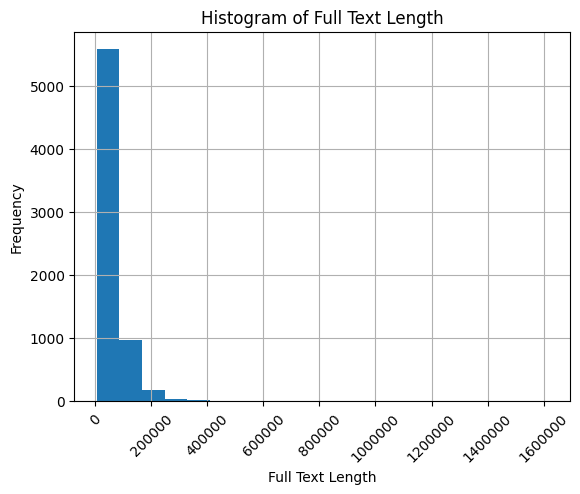

In [ ]:
text_lengths = [len(item['text']) for item in full_text_citing]
plt.hist(text_lengths, bins=20)
plt.xlabel('Full Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Full Text Length')
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.show()


In [ ]:
#TOOD: Full Text TF_IDF (training data)
tfidf_vectorizer1 = TfidfVectorizer(
    stop_words='english',
    max_features=60000,
    ngram_range=(1, 1),
    strip_accents='unicode',
    sublinear_tf= True
    )
tfidf_citing1, tfidf_nonciting1 = create_tfidf_matrix(full_text_citing, full_text_nonciting, tfidf_vectorizer1)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing1.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting1.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 60000
Shape of citing TF-IDF matrix: (6831, 60000)
Shape of citedTF-IDF matrix: (16837, 60000)


In [ ]:
cosine_similarities1 = linear_kernel(tfidf_citing1,tfidf_nonciting1)
cosine_similarities1

array([[0.15947739, 0.07032548, 0.09156124, ..., 0.13019904, 0.03670153,
        0.09870777],
       [0.07057263, 0.04357972, 0.1327829 , ..., 0.05593157, 0.09996435,
        0.08407639],
       [0.11183946, 0.0705481 , 0.1226307 , ..., 0.12903391, 0.05834044,
        0.12465939],
       ...,
       [0.11967054, 0.10242866, 0.14872317, ..., 0.13478352, 0.07522594,
        0.15042447],
       [0.06897126, 0.04485122, 0.07983267, ..., 0.05510985, 0.07207176,
        0.08667064],
       [0.04923623, 0.02804154, 0.05677148, ..., 0.0419151 , 0.04557125,
        0.07867079]])

In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank_full_text_train1 = top_k_ranks(full_text_citing, full_text_nonciting, cosine_similarities1, k=k)

# Calculate the metrics
true_labels1, predicted_labels1, not_in_citation_mapping1 = \
    get_true_and_predicted(mapping_dict, top_k_rank_full_text_train1)

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_tfidf = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_tfidf, 4))
print("Recall at 20:", round(recall_at_20_claim1_tfidf, 4))
print("Recall at 50:", round(recall_at_50_claim1_tfidf, 4))
print("Recall at 100:", round(recall_at_100_claim1_tfidf, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.3472
Recall at 20: 0.4252
Recall at 50: 0.5392
Recall at 100: 0.6206
Mean ranking: 49.9826
Mean average precision: 0.2024
Number of patents measured: 6831
Number of patents not in the citation: 0


In [ ]:
# for test
print("# --- On test corpus --- #")
full_text_citing_test = create_corpus(json_citing_test , 'fulltext')
full_text_nonciting = create_corpus(json_nonciting, 'fulltext')


tfidf_citing_test1, tfidf_nonciting_test1 = create_tfidf_matrix(full_text_citing_test, full_text_nonciting, tfidf_vectorizer1)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing_test1.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting_test1.shape}")
cosine_similarities_test1 = linear_kernel(tfidf_citing_test1, tfidf_nonciting_test1)
cosine_similarities_test1

k = 100
top_k_rank_full_text_test1 = top_k_ranks(full_text_citing_test, full_text_nonciting, cosine_similarities_test1, k=k)


# --- On test corpus --- #
Vectorizing descriptions...


TF-IDF:   0%|          | 0/17837 [00:00<?, ?it/s]

Size of vocabulary: 60000
Shape of citing TF-IDF matrix: (1000, 60000)
Shape of citedTF-IDF matrix: (16837, 60000)


## Combine 'title', 'abstract', 'claim1', 'claims':

- we will combine all the sections but we weight each part (testing to see if it works)
- we will test if perfoming some processing on the text gives better recall
- play with the parameters of tfidf

In [ ]:
# creation of train and test corpus for the fours sections
# 'title', 'abstract', 'claim1', 'claims'
citing_corpus_title = create_corpus(json_citing_train, 'title')
citing_corpus_abstract = create_corpus(json_citing_train, 'abstract')
citing_corpus_claim1 = create_corpus(json_citing_train, 'claim1')
citing_corpus_claims = create_corpus(json_citing_train, 'claims')

nonciting_corpus_title = create_corpus(json_nonciting, 'title')
nonciting_corpus_abstract = create_corpus(json_nonciting, 'abstract')
nonciting_corpus_claim1 = create_corpus(json_nonciting, 'claim1')
nonciting_corpus_claims = create_corpus(json_nonciting, 'claims')


Number of documents without title: 0
Number of documents without abstract: 0
Number of documents without claim 1: 0
Number of documents without claims: 0
Number of documents without title: 0
Number of documents without abstract: 7811
Removing 7811 documents without required text
Number of documents without claim 1: 3
Removing 3 documents without required text
Number of documents without claims: 3
Removing 3 documents without required text


In [ ]:
print(f"citing_corpus_title: {citing_corpus_title[:2]}")
print(f"citing_corpus_abstract: {citing_corpus_abstract[:2]}")
print(f"citing_corpus_claim1: {citing_corpus_claim1[:2]}")
print(f"citing_corpus_claims: {citing_corpus_claims[:2]}")

print(f"nonciting_corpus_title: {nonciting_corpus_title[:2]}")
print(f"nonciting_corpus_abstract: {nonciting_corpus_abstract[:2]}")
print(f"nonciting_corpus_claim1: {nonciting_corpus_claim1[:2]}")
print(f"nonciting_corpus_claims: {nonciting_corpus_claims[:2]}")


citing_corpus_title: [{'id': '3650293A1', 'text': 'DEVICE FOR CONTROLLING THE BRAKING OF A TRAILER'}, {'id': '3694265A1', 'text': 'TIME DIVISION MULTIPLEXING OF SYNCHRONIZATION CHANNELS'}]
citing_corpus_abstract: [{'id': '3650293A1', 'text': 'The device (1) for controlling the braking of a trailer, comprises: one control line (2) connectable to a source of a work fluid at a first pressure; a braking line (3) connectable to the service braking system (4) of the trailer and communicating with the control line (2); one additional line (5) connectable to a source of a work fluid at a second pressure; one emergency line (6) connectable to the additional line (5) and connectable to the emergency and/or parking brake (7) of the trailer of the type of a hydraulically released spring brake; one discharge line (8) of the work fluid communicating with a collection tank (9); first valve means operable between a braking position, wherein the additional line (5) is isolated from the discharge line (

In [ ]:
def create_weighted_corpus(corpus, sections_with_weights):
    """
    Combine multiple patent text sections into a single weighted corpus.

    Parameters:
        corpus (list): List of patent documents (JSON/dict format)
        sections_with_weights (list): List of tuples specifying (text_type, weight)
            Example: [("title", 1), ("abstract", 2), ("claims", 3)]

    Returns:
        list: Combined corpus with weighted text fields
    """
    weighted_corpus = []

    for doc in tqdm(corpus, desc="Creating weighted corpus"):
        combined_text = []
        app_id = doc["Application_Number"] + doc["Application_Category"]

        # Extract and weight each section
        for section, weight in sections_with_weights:
            try:
                # Replicate the text extraction logic from create_corpus()
                if section == "title":
                    text = doc["Content"]["title"]
                elif section == "abstract":
                    text = doc["Content"]["pa01"]
                elif section == "claim1":
                    text = doc["Content"]["c-en-0001"]
                elif section == "claims":
                    claims = [v for k,v in doc["Content"].items() if k.startswith("c-en-")]
                    text = " ".join(claims) if claims else None
                elif section == "description":
                    desc = [v for k,v in doc["Content"].items() if k.startswith("p")]
                    text = " ".join(desc) if desc else None
                elif section == "fulltext":
                    text = " ".join(doc["Content"].values())

                # Add weighted text (repeat text 'weight' times)
                if text:
                    combined_text.extend([text] * weight)

            except KeyError:
                continue  # Skip if section is missing

        if combined_text:
            weighted_corpus.append({
                "id": app_id,
                "text": " ".join(combined_text)
            })

    print(f"Created weighted corpus with {len(weighted_corpus)} documents")
    return weighted_corpus

In [ ]:
# Define section weights
section_weights = [
    ("title", 2),
    ("abstract", 2),
    ("claims", 3)
]

# Create combined corpora
citing_weighted = create_weighted_corpus(json_citing_train, section_weights)
nonciting_weighted = create_weighted_corpus(json_nonciting, section_weights)
citing_weighted_test = create_weighted_corpus(json_citing_test, section_weights)

Creating weighted corpus:   0%|          | 0/6831 [00:00<?, ?it/s]

Created weighted corpus with 6831 documents


Creating weighted corpus:   0%|          | 0/16837 [00:00<?, ?it/s]

Created weighted corpus with 16837 documents


Creating weighted corpus:   0%|          | 0/1000 [00:00<?, ?it/s]

Created weighted corpus with 1000 documents


In [ ]:
# define the vectorizer
tfidf_vectorizer_combined_text = TfidfVectorizer(
    stop_words='english',
    max_features=80000,
    ngram_range=(1, 1),
    strip_accents='unicode',
    sublinear_tf= True,
    )
tfidf_citing_combined_text, tfidf_nonciting_combined_text = create_tfidf_matrix(citing_weighted, nonciting_weighted, tfidf_vectorizer_combined_text)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing_combined_text.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting_combined_text.shape}")

Vectorizing descriptions...


TF-IDF:   0%|          | 0/23668 [00:00<?, ?it/s]

Size of vocabulary: 80000
Shape of citing TF-IDF matrix: (6831, 80000)
Shape of citedTF-IDF matrix: (16837, 80000)


In [ ]:
# compute the cosin sim
cosine_similarities_combined_text = linear_kernel(tfidf_citing_combined_text, tfidf_nonciting_combined_text)
cosine_similarities_combined_text

array([[0.07893686, 0.05638546, 0.05697324, ..., 0.11101624, 0.02324109,
        0.0654046 ],
       [0.02460792, 0.01093089, 0.03900988, ..., 0.0290951 , 0.06226895,
        0.02564064],
       [0.01884193, 0.02445447, 0.0508982 , ..., 0.06923877, 0.01996435,
        0.02570629],
       ...,
       [0.03053324, 0.03225257, 0.0501282 , ..., 0.03764765, 0.03515354,
        0.02739854],
       [0.04344242, 0.03599629, 0.02330674, ..., 0.0199249 , 0.0330305 ,
        0.04228714],
       [0.01254185, 0.02097445, 0.04135774, ..., 0.0081764 , 0.00992039,
        0.03780251]])

In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank_combined_text_train = top_k_ranks(citing_weighted, nonciting_weighted, cosine_similarities_combined_text, k=k)
# Calculate the metrics
true_labels_combined_text_train, predicted_labels_combined_text_train, not_in_citation_mapping_combined_text = \
    get_true_and_predicted(mapping_dict, top_k_rank_combined_text_train)

mean_rank_combined_text_train = mean_ranking(true_labels_combined_text_train, predicted_labels_combined_text_train)
mean_average_precision_val_combined_text_train = mean_average_precision(true_labels_combined_text_train, predicted_labels_combined_text_train)
recall_at_10_combined_text_tfidf = mean_recall_at_k(true_labels_combined_text_train, predicted_labels_combined_text_train, k=10)
recall_at_20_combined_text_tfidf = mean_recall_at_k(true_labels_combined_text_train, predicted_labels_combined_text_train, k=20)
recall_at_50_combined_text_tfidf = mean_recall_at_k(true_labels_combined_text_train, predicted_labels_combined_text_train, k=50)
recall_at_100_combined_text_tfidf = mean_recall_at_k(true_labels_combined_text_train, predicted_labels_combined_text_train, k=100)

print("Recall at 10:", round(recall_at_10_combined_text_tfidf, 4))
print("Recall at 20:", round(recall_at_20_combined_text_tfidf, 4))
print("Recall at 50:", round(recall_at_50_combined_text_tfidf, 4))
print("Recall at 100:", round(recall_at_100_combined_text_tfidf, 4))


print("Mean ranking:", round(mean_rank_combined_text_train, 4))
print("Mean average precision:", round(mean_average_precision_val_combined_text_train, 4))
print("Number of patents measured:", len(predicted_labels_combined_text_train))
print("Number of patents not in the citation:", not_in_citation_mapping_combined_text)

Recall at 10: 0.6191
Recall at 20: 0.701
Recall at 50: 0.7956
Recall at 100: 0.8563
Mean ranking: 24.7913
Mean average precision: 0.406
Number of patents measured: 6831
Number of patents not in the citation: 0


In [ ]:
# for test
print("# --- On test corpus --- #")


tfidf_citing_combined_text_test, tfidf_nonciting_combined_text_test = create_tfidf_matrix(citing_weighted_test, nonciting_weighted, tfidf_vectorizer_combined_text)

print(f"Shape of citing TF-IDF matrix: {tfidf_citing_combined_text_test.shape}")
print(f"Shape of citedTF-IDF matrix: {tfidf_nonciting_combined_text_test.shape}")
cosine_similarities_combined_text_test = linear_kernel(tfidf_citing_combined_text_test, tfidf_nonciting_combined_text_test)
cosine_similarities_combined_text_test

k = 100
top_k_rankg_combined_text_test= top_k_ranks(citing_weighted_test, nonciting_weighted, cosine_similarities_combined_text_test, k=k)


# --- On test corpus --- #
Vectorizing descriptions...


TF-IDF:   0%|          | 0/17837 [00:00<?, ?it/s]

Size of vocabulary: 80000
Shape of citing TF-IDF matrix: (1000, 80000)
Shape of citedTF-IDF matrix: (16837, 80000)


In [ ]:
# save the result to json file

with open('prediction1.json', 'w') as f:
    json.dump(top_k_rankg_combined_text_test, f)

# 3.0 BM-25

## 3.1 Initialize BM25 Class

In [ ]:
class BM25Score:
    """BM25 scoring algorithm implementation for document ranking."""

    def __init__(self, vectorized_docs, k1=1.5, b=0.75):
        """
        Initialize the BM25Score object.

        Parameters:
        - vectorized_docs (scipy.sparse.csr_matrix): Sparse matrix of word counts representing vectorized documents.
        - k1 (float, optional): Tuning parameter that controls term frequency normalization. Default is 1.5.
        - b (float, optional): Tuning parameter that controls the impact of document length normalization. Default is 0.75.
        """
        self.k1 = k1
        self.b = b
        self.vectorized_docs = vectorized_docs

    def fit(self, vectorized_queries=None, query_ids=None, args=None):
        """
        Fit the BM25 model to the provided vectorized documents.

        Parameters:
        - vectorized_queries (scipy.sparse.csr_matrix, optional): Sparse matrix of word counts representing vectorized queries. Default is None.
        - query_ids (list, optional): List of query IDs. Default is None.
        - args (dict, optional): Additional arguments for grid search integration. Default is None.

        Returns:
        - self (BM25Score): Returns the instance of the BM25Score object after fitting.
        """
        self.n_d = self.vectorized_docs.sum(axis=1).reshape(-1, 1).A
        self.avgdl = np.mean(self.n_d)
        self.n_docs = self.vectorized_docs.shape[0]

        self.nq = np.sum(self.vectorized_docs > 0, axis=0).reshape(1, -1)
        self.idf = np.log(((self.n_docs - self.nq + 0.5) / (self.nq + 0.5)) + 1).A
        return self

    def predict(self, vectorized_queries):
        """
        Predict relevance scores for the given vectorized queries.

        Parameters:
        - vectorized_queries (scipy.sparse.csr_matrix): Sparse matrix of word counts representing vectorized queries.

        Returns:
        - scores (numpy.ndarray): Array of relevance scores for the queries.
        """
        idx_tokens = np.argwhere(vectorized_queries.sum(axis=0) > 0).reshape(-1)
        vectorized_queries = vectorized_queries[:, idx_tokens]
        vectorized_docs = self.vectorized_docs[:, idx_tokens].toarray()
        idf = self.idf[:, idx_tokens]

        scores = idf * (
            (vectorized_docs * (self.k1 + 1)) / \
            (
                vectorized_docs + \
                self.k1 * (1 - self.b + self.b * (self.n_d / self.avgdl))
            )
        )

        return (vectorized_queries > 0).astype(np.int8) @ scores.T

def create_bm25_matrix(citing_dataset, nonciting_dataset, vectorizer=CountVectorizer()):
    """
    Creates BM25 similarity scores for the given citing and non-citing datasets based on the specified text column.

    Parameters:
    citing_dataset (json): DataFrame containing citing patents.
    nonciting_dataset (json): DataFrame containing non-citing patents.
    vectorizer (CountVectorizer, optional): CountVectorizer object for vectorizing text data.
                                            Defaults to CountVectorizer().

    Returns:
    array: Similarity scores matrix between citing and non-citing patents.
    """
    all_text_citing = [patent['text'] for patent in citing_dataset]
    all_text_nonciting = [patent['text'] for patent in nonciting_dataset]

    # Vectorizing descriptions
    print("Vectorizing descriptions...")
    vectorizer.fit(all_text_citing + all_text_nonciting)
    count_matrix_citing = vectorizer.transform(all_text_citing)
    count_matrix_nonciting = vectorizer.transform(all_text_nonciting)

    # Using BM25 scoring
    print("Computing BM25 scores...")
    bm25 = BM25Score(count_matrix_nonciting)
    bm25.fit()
    bm25_scores = bm25.predict(count_matrix_citing)

    return bm25_scores

## 3.2 'Title' BM25

In [ ]:
# Create BM25 similarity scores
bm25_scores = create_bm25_matrix(title_citing_train, title_nonciting)

print(f"Shape of BM25 scores matrix: {bm25_scores.shape}")

Vectorizing descriptions...
Computing BM25 scores...
Shape of BM25 scores matrix: (6831, 16837)


In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(title_citing_train, title_nonciting, bm25_scores, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_titles_bm25, 4))
print("Recall at 20:", round(recall_at_20_titles_bm25, 4))
print("Recall at 50:", round(recall_at_50_titles_bm25, 4))
print("Recall at 100:", round(recall_at_100_titles_bm25, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.2687
Recall at 20: 0.3297
Recall at 50: 0.4115
Recall at 100: 0.4719
Mean ranking: 61.6857
Mean average precision: 0.1655
Number of patents measured: 6831
Number of patents not in the citation: 0


In [ ]:
# on test
print("# --- On test corpus --- #")
bm25_scores_test = create_bm25_matrix(title_citing_test, title_nonciting)
top_k_rank_title_test = top_k_ranks(title_citing_test, title_nonciting, bm25_scores_test, k=k)

# --- On test corpus --- #
Vectorizing descriptions...
Computing BM25 scores...


## 3.3 'Claims1' BM25

In [ ]:
print(f"Number of citing: {len(claim1_citing)}")
print(f"Number of nonciting: {len(claim1_nonciting)}")
print(f"Sum: {len(claim1_citing) + len(claim1_nonciting)}")

Number of citing: 6831
Number of nonciting: 16834
Sum: 23665


In [ ]:
# Create BM25 similarity scores
bm25_scores = create_bm25_matrix(claim1_citing, claim1_nonciting)

print(f"Shape of BM25 scores matrix: {bm25_scores.shape}")

Vectorizing descriptions...
Computing BM25 scores...


In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(claim1_citing, claim1_nonciting, bm25_scores, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)

mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_claim1_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_claim1_bm25, 4))
print("Recall at 20:", round(recall_at_20_claim1_bm25, 4))
print("Recall at 50:", round(recall_at_50_claim1_bm25, 4))
print("Recall at 100:", round(recall_at_100_claim1_bm25, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

In [ ]:
len(true_labels)

6831

In [ ]:
len(predicted_labels[0])

100

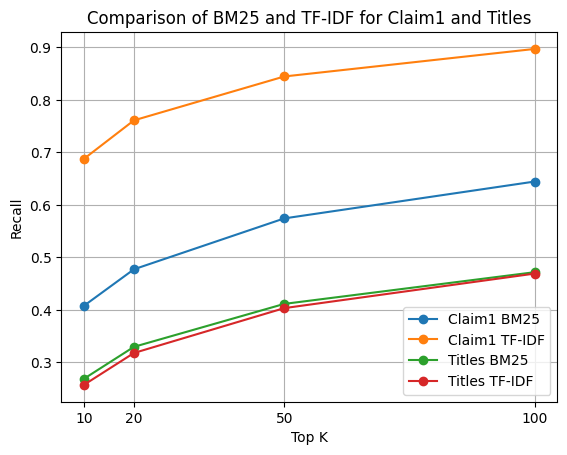

In [ ]:
k_values = [10, 20, 50, 100]

plt.plot(k_values, [recall_at_10_claim1_bm25, recall_at_20_claim1_bm25, recall_at_50_claim1_bm25, recall_at_100_claim1_bm25], label='Claim1 BM25', marker='o')
plt.plot(k_values, [recall_at_10_claim1_tfidf, recall_at_20_claim1_tfidf, recall_at_50_claim1_tfidf, recall_at_100_claim1_tfidf], label='Claim1 TF-IDF', marker='o')
plt.plot(k_values, [recall_at_10_titles_bm25, recall_at_20_titles_bm25, recall_at_50_titles_bm25, recall_at_100_titles_bm25], label='Titles BM25', marker='o')
plt.plot(k_values, [recall_at_10_titles_tfidf, recall_at_20_titles_tfidf, recall_at_50_titles_tfidf, recall_at_100_titles_tfidf], label='Titles TF-IDF', marker='o')

plt.xlabel('Top K')
plt.ylabel('Recall')
plt.title('Comparison of BM25 and TF-IDF for Claim1 and Titles')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

## 3.4 'All Content' BM25

In [ ]:
# Create BM25 similarity scores on full_text
bm25_scores_full_text = create_bm25_matrix(full_text_citing_train, full_text_citing_train)

print(f"Shape of BM25 scores matrix: {bm25_scores_full_text.shape}")

In [ ]:
# Get the top k ranks for each citing patent
k = 100
top_k_rank = top_k_ranks(full_text_citing_train, full_text_citing_train, bm25_scores_full_text, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_titles_bm25 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_titles_bm25, 4))
print("Recall at 20:", round(recall_at_20_titles_bm25, 4))
print("Recall at 50:", round(recall_at_50_titles_bm25, 4))
print("Recall at 100:", round(recall_at_100_titles_bm25, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

In [ ]:
# on test full_text
print("# --- On test corpus --- #")

bm25_scores_full_text_test = create_bm25_matrix(full_text_citing_test, full_text_nonciting)
top_k_rank_full_text_test = top_k_ranks(full_text_citing_test, full_text_nonciting, bm25_scores_full_text_test, k=k)

### Combined text

In [ ]:
section_weights = [
    ("claims", 3),
    ("abstract", 2),
    ("title", 1)
]

# Test different (k1, b) combinations
param_grid = {
    'k1': [1.2, 1.5, 1.8],
    'b': [0.6, 0.75, 0.9]
}

# 1. Create weighted corpus
section_weights = [("claims", 3), ("abstract", 2)]
citing_weighted = create_weighted_corpus(json_citing_train, section_weights)
nonciting_weighted = create_weighted_corpus(json_nonciting, section_weights)

# 2. Preprocess with stemming and n-grams
vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    stop_words=custom_stopwords,
    preprocessor=stemmer.stem
)

# 3. Tune BM25 parameters (k1=1.5, b=0.75)
bm25_scores = create_bm25_matrix(citing_weighted, nonciting_weighted, vectorizer)

# 4. Generate top-100 rankings
top_100 = top_k_ranks(citing_weighted, nonciting_weighted, bm25_scores, k=100)


# 4.0 Get Test Predictions for CodaBench

In [ ]:
# Create BM25 similarity scores
bm25_scores = create_bm25_matrix(title_citing_test, title_nonciting)
top_k_rank = top_k_ranks(title_citing_test, title_nonciting, bm25_scores, k=k)

print(f"Shape of BM25 scores matrix: {bm25_scores.shape}")

Vectorizing descriptions...
Computing BM25 scores...
Shape of BM25 scores matrix: (1000, 16837)


In [ ]:
with open('prediction1.json', 'w') as f:
    json.dump(top_k_rank, f)